In [166]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

data = pd.read_csv('data/data.csv', index_col=None)
data

,level,long,lat
0,0,-0.130495,51.511534
1,0,-0.140844,51.514684
2,0,-0.135874,51.515684
3,0,-0.110329,51.518250
4,0,-0.125708,51.507725
...,...,...,...
8953,1,-0.134599,51.511608
8954,1,-0.125331,51.513753
8955,1,-0.131706,51.509404
8956,1,-0.147526,51.516597


In [167]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


scaler = MinMaxScaler()
X = scaler.fit_transform(data.loc[:, ['long', 'lat']])
Y = scaler.fit_transform(data.loc[:, ['level']])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [184]:
from keras_tuner.tuners import BayesianOptimization

def build_model(hp):

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size', values=[2, 3]),
        activation=hp.Choice('activation', values=['relu', 'tanh']),
        input_shape=(X_train.shape[1], 1),
        padding='same'))
        
    model.add(tf.keras.layers.MaxPooling1D(pool_size=1))

    model.add(tf.keras.layers.Dense(2))
    model.add(tf.keras.layers.Dense(2))

    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer='adam', loss='mse')
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_loss', 
    max_trials=10,     
    executions_per_trial=10,
    directory='new_keras_optimise_logs', 
    project_name='keras_tuning'
)

tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Trial 10 Complete [00h 00m 25s]
val_loss: 0.14528629034757615

Best val_loss So Far: 0.14514492452144623
Total elapsed time: 00h 03m 48s


In [209]:
import os

checkpoint_path = "training_1/cp1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [210]:
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), callbacks=[cp_callback])

Epoch 1/50
150/224 [===================>..........] - ETA: 0s - loss: 0.1780
Epoch 1: saving model to training_1/cp1.ckpt
224/224 [==============================] - 0s 1ms/step - loss: 0.1692 - val_loss: 0.1498
Epoch 2/50
166/224 [=====================>........] - ETA: 0s - loss: 0.1471
Epoch 2: saving model to training_1/cp1.ckpt
224/224 [==============================] - 0s 786us/step - loss: 0.1466 - val_loss: 0.1465
Epoch 3/50
170/224 [=====================>........] - ETA: 0s - loss: 0.1455
Epoch 3: saving model to training_1/cp1.ckpt
224/224 [==============================] - 0s 776us/step - loss: 0.1467 - val_loss: 0.1463
Epoch 4/50
175/224 [======================>.......] - ETA: 0s - loss: 0.1450
Epoch 4: saving model to training_1/cp1.ckpt
224/224 [==============================] - 0s 751us/step - loss: 0.1449 - val_loss: 0.1471
Epoch 5/50
210/224 [===========================>..] - ETA: 0s - loss: 0.1452
Epoch 5: saving model to training_1/cp1.ckpt
224/224 [===================

In [211]:
new_model = tuner.hypermodel.build(best_hps)
new_model.load_weights(checkpoint_path)

In [212]:
predictions = new_model.predict(X_train, batch_size=len(X_train))
predictions

1/1 [==============================] - 0s 41ms/step


array([[[0.6710303 ],
        [0.6965246 ]],

       [[0.651154  ],
        [0.6420587 ]],

       [[0.70924276],
        [0.71199626]],

       ...,

       [[0.5129047 ],
        [0.5388785 ]],

       [[0.7063937 ],
        [0.695563  ]],

       [[0.6713104 ],
        [0.6753432 ]]], dtype=float32)

In [213]:
X_train

array([[0.61735265, 0.83947789],
       [0.60650724, 0.65978356],
       [0.27902274, 0.76869743],
       ...,
       [0.00618305, 0.89925542],
       [0.02874284, 0.71292919],
       [0.56479671, 0.67913665]])

In [208]:
best_model.evaluate(X_test, Y_test)

AttributeError: 'CheckpointLoadStatus' object has no attribute 'fit'

In [162]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions = best_model.predict(X_test)

56/56 [==============================] - 0s 531us/step


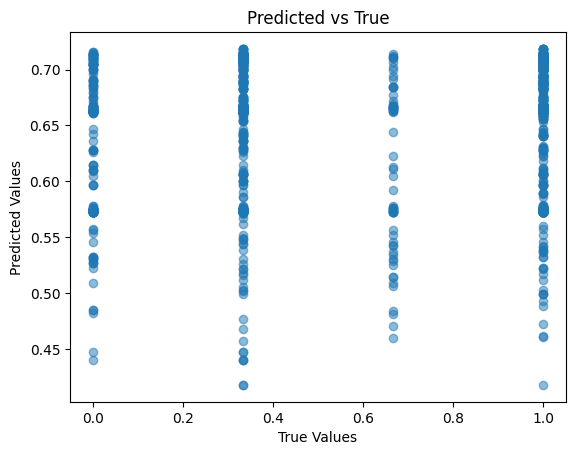

In [163]:
plt.scatter(Y_test[:, 0], predictions[:, 0], alpha=0.5)
plt.title("Predicted vs True")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [164]:
mse_level = mean_squared_error(Y_test[:, 0], predictions[:, 0])
rmse_level = np.sqrt(mse_level)
mae_level = mean_absolute_error(Y_test[:, 0], predictions[:, 0])

print("Crime Level - MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_level, rmse_level, mae_level))

Crime Level - MSE: 0.1432, RMSE: 0.3785, MAE: 0.3566
